In [1]:
# %pip install --upgrade langchain langsmith langgraph langserve langchain_openai openai python-dotenv javascript numpy genson fastapi
%reload_ext autoreload
%autoreload 2

/Users/spark_near/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


fetching queryapi docs


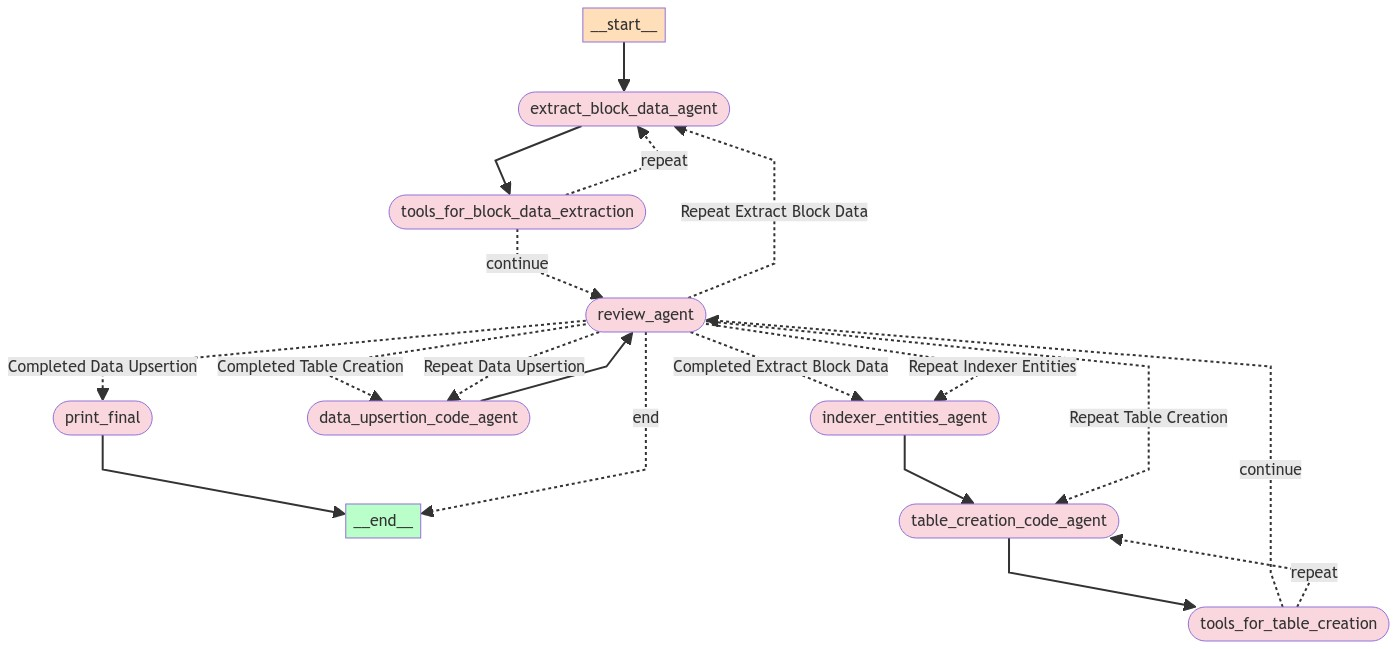

In [2]:
# Setup
from dotenv import load_dotenv
import os
from graph.master_graph import create_graph, create_graph_no_human_review
from IPython.display import Image, display

# Load .env file
load_dotenv('.env')

# Set model variables
OPENAI_BASE_URL = "https://api.openai.com/v1"
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
OPENAI_ORGANIZATION = os.getenv("OPENAI_ORGANIZATION")

# Set environment variables
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = os.getenv("LANGCHAIN_PROJECT")

# Create Graph
workflow = create_graph()
# workflow = create_graph_no_human_review()
app = workflow.compile()
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [1]:
# Define question and invoke app
from langchain_core.messages import HumanMessage

question = """
    Extract all FunctionCalls where receiverId is 'app.nearcrowd.near'. For each function call, I need signerId, block height, receiptId, block datetime, methodName. 
    Also add all fields from args that are decoded from base64-encoded JSON. I only need actions for successful receipts. 
    Use block height 119688212 for parsing the JS code, and only pull data from the last 2 days 
    """

inputs = {
    "messages":[HumanMessage(content=question)],
    "original_prompt":question,
    "block_heights":[],
    "entity_schema": "",
    "block_data_extraction_code":"",
    "table_creation_code":"",
    "data_upsertion_code": "",
    "indexer_entities_description":"",
    "iterations": 0,
    "error":"",
    "should_continue": False,
    }

# RUN MASTER APP
result = app.invoke(inputs)
table_creation_code = result['table_creation_code'].replace("\\n","\n")
block_data_extraction_code = result['block_data_extraction_code'].replace("\\n","\n")
data_upsertion_code = result['data_upsertion_code'].replace("\\n","\n")

In [2]:
print(f'SQL DDL: {table_creation_code}')
print(f'Data Upsertion Logic: {data_upsertion_code}')